# Comparing Metrics
Given we will be creating metrics from different models, potentially wanting to compare the performance of different parameters in these models, we need a way to quickly compare metrics across the set of output variables quickly. Lets first create some metrics for two different PLS Regression models and see how then we are able to compare and calculate which is better.

In [1]:
from spectroscopy import PLSEstimator, Metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

sns.set_style("whitegrid")


------- Loading data -------
Loading data for dataset ( dried | 2 )
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 144 samples.

------- Partition data -------
Train set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.

Test set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.
Now partitioning features and targets for train data...
X and y have shapes (115, 4200), (115, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.
Now partitioning features and targets for test data...
X and y have shapes (29, 4200), (29, 13):

------- Finding best parameter -------
Comparing train and test features...
Comparing train and test targets..

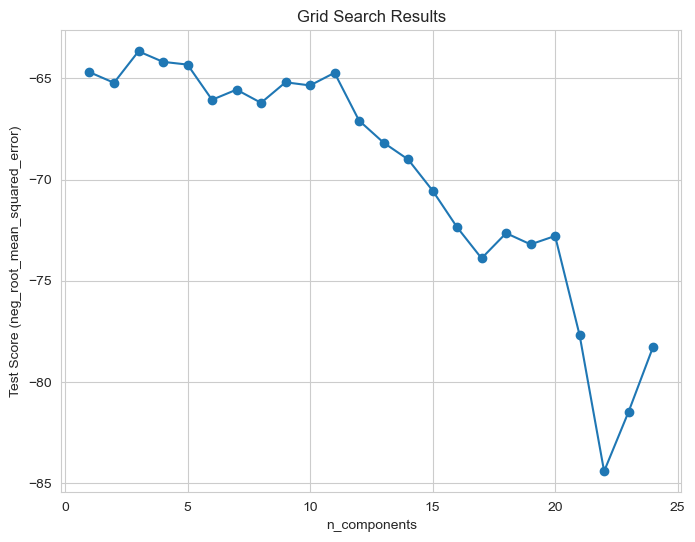


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.

------- Loading data -------
Loading data for dataset ( fresh | 2 )
Data comprises of {2} seasons, and {'FRESH'} sample modes.
Dataset has 144 samples.

------- Partition data -------
Train set composition:
Data comprises of {2} seasons, and {'FRESH'} sample modes.
Dataset has 115 samples.

Test set composition:
Data comprises of {2} seasons, and {'FRESH'} sample modes.
Dataset has 29 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {2} seasons, and {'FRESH'} sample modes.
Dataset has 115 samples.
Now partitioning features and targets for train data...
X and y have shapes (115, 4200), (115, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {2} seasons, and {'FRESH'} sample modes.
Dataset has 29 samples.
Now partitioning features and targets for test d

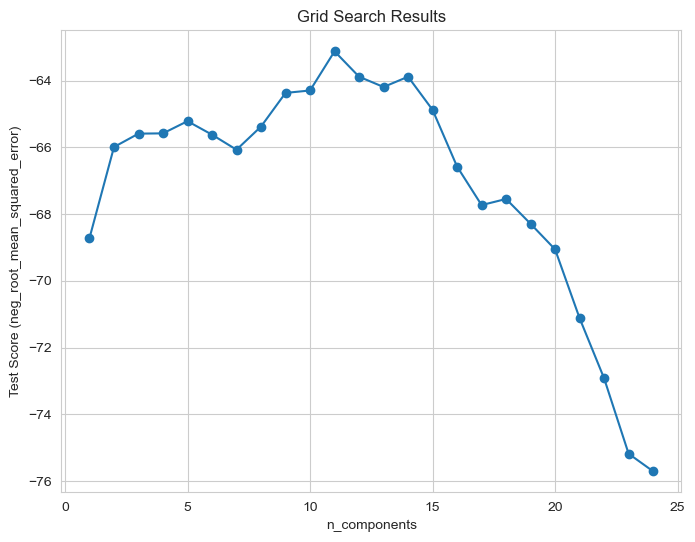


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.

------- Loading data -------
All dataset are loading
Data comprises of {1, 2, 3, 4} seasons, and {'FRESH', 'DRIED'} sample modes.
Dataset has 695 samples.
Data comprises of {1, 2, 3, 4} seasons, and {'FRESH', 'DRIED'} sample modes.
Dataset has 695 samples.
Data comprises of {1, 2, 3, 4} seasons, and {'DRIED'} sample modes.
Dataset has 406 samples.

------- Partition data -------
Train set composition:
Data comprises of {2, 3, 4} seasons, and {'DRIED'} sample modes.
Dataset has 366 samples.

Test set composition:
Data comprises of {1} seasons, and {'DRIED'} sample modes.
Dataset has 40 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {2, 3, 4} seasons, and {'DRIED'} sample modes.
Dataset has 346 samples.
Now partitioning features and targets for train data...
X and y have shapes (346, 42

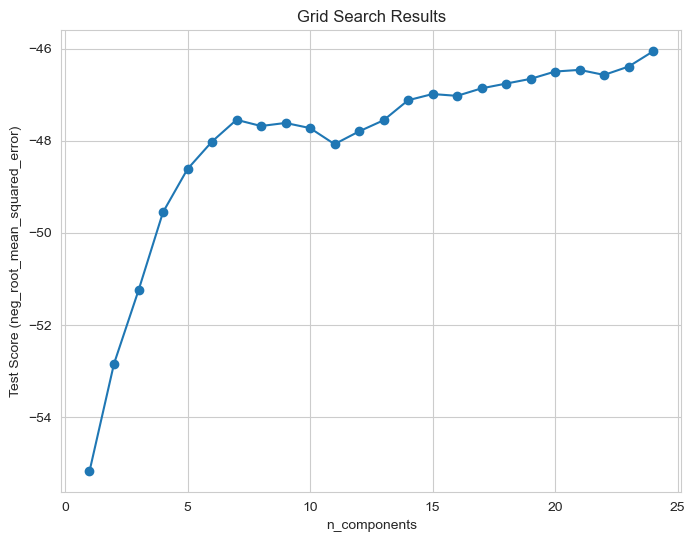


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.


In [2]:
pls1 = PLSEstimator()
pls1.load_dataset(leaf_state="dried", season=2)
pls1.partition(test_size=0.2)
pls1.preprocess("train", 0.5, 0.5, 0.5, impute_target_method="knn", impute_feature_method="neighbour_avg")
pls1.preprocess("test", 0.5, 1.1, 0.2, impute_target_method=None, impute_feature_method="neighbour_avg")
pls1.find_component()
pls1.fit_predict()

pls2 = PLSEstimator()
pls2.load_dataset(leaf_state="fresh", season=2)
pls2.partition(test_size=0.2)
pls2.preprocess("train", 0.5, 0.5, 0.5, impute_target_method="knn", impute_feature_method="neighbour_avg")
pls2.preprocess("test", 0.5, 1.1, 0.2, impute_target_method=None, impute_feature_method="neighbour_avg")
pls2.find_component()
pls2.fit_predict()

pls3 = PLSEstimator()
pls3.load_dataset()
pls3.filter_seasons([1,2,3,4])
pls3.filter_leaf_state("DRIED")
pls3.partition(test_set=(["DRIED"],[1]))
pls3.preprocess("train", 0.5, 0.5, 0.5, impute_target_method="knn", impute_feature_method="neighbour_avg")
pls3.preprocess("test", 0.5, 1.1, 0.2, impute_target_method=None, impute_feature_method="neighbour_avg")
pls3.find_component()
pls3.fit_predict()

In [3]:
metrics1 = Metrics(pls1.y_pred, pls1.y_test, pls1.leaf_state, pls1.season)
metrics2 = Metrics(pls2.y_pred, pls2.y_test, pls2.leaf_state, pls2.season)

We need to make sure both sets of results are the same shape first. Any differences between the shapes and alignment between target results (rows) and metrics (columns) needs to be addressed, such that we have something that can be compared.

In [4]:
def compare_results(a_result: pd.DataFrame, b_result: pd.DataFrame, calc: str = "difference") -> pd.DataFrame:

    if isinstance(a_result.index, pd.MultiIndex) or isinstance(b_result.index, pd.MultiIndex):
        print("DataFrame has a multilevel index. Function requires that both dataframes have a single level row index of element names.")
        return

    targets = a_result.index.get_level_values("target")
    metrics = a_result.columns

    if a_result.shape != b_result.shape:
        print(f"Shape of results are not equal: a_result={a_result.shape}, b_result={b_result.shape}")
        print("Refactoring so that they are equal...")

        if a_result.shape[0] != b_result.shape[0]:
            targets = compare_targets(a_result, b_result)

        if a_result.shape[1] != b_result.shape[1]:
            metrics = compare_metric_cols(a_result, b_result)

    return calculate_difference(a_result.loc[targets, metrics], b_result.loc[targets, metrics], calc)


def compare_targets(a: pd.DataFrame, b: pd.DataFrame) -> None:

    a_targets = set(a.index.get_level_targets("target").to_list())
    b_targets = set(b.index.get_level_targets("target").to_list())
    new_targets = a_targets.intersection(b_targets)

    print(f"Results show following targets exist in one set and not other:")
    print(f"\ta_targets={a_targets - b_targets}, b_targets={b_targets - a_targets}")
    print(f"Only comparing metrics for {new_targets} targets, excluding {new_targets.difference(a_targets + b_targets)}")

    return list(new_targets)


def compare_metric_cols(a: pd.DataFrame, b: pd.DataFrame) -> None:

    a_cols = set(a.columns.to_list())
    b_cols = set(b.columns.to_list())
    new_cols = a_cols.intersection(b_cols)

    print(f"Results show different number of metrics. Common metrics between both result sets are: {new_cols}")

    return list(new_cols)


def calculate_difference(a: pd.DataFrame, b: pd.DataFrame, calc: str) -> pd.DataFrame:
    """
    Calculate the difference between two sets of results, based on the calculation parameter provided.
    :param a: Model results dataframe
    :param b: Mode results dataframe
    :param calc: differece, percentage, ratio
    :return: pd.DataFrame of results differences
    """
    try:
        if calc == "difference":
            return b - a
        if calc == "percentage":
            return (b - a) / a * 100
        if calc == "ratio":
            return b / a
    except Exception as e:
        raise ValueError(f"Failed to calculate the difference between two dataframes, with the following error:"
                         f"\n\t{e}")



In [5]:
print(metrics1.results.shape)
print(metrics2.results.shape)
print(metrics1.results.head())

(13, 6)
(13, 6)
                                r2           mse        rmse     rrmse  \
leaf_state season target                                                 
dried      2      Al      0.589266  18479.401492  135.938962  0.125244   
                  B       0.607453    628.573857   25.071375  0.090613   
                  Ca      0.164312      0.298594    0.546438  0.057384   
                  Cu      0.100787     28.458342    5.334636  0.128250   
                  Fe      0.193593  31835.697816  178.425609  0.149479   

                                 mae      mape  
leaf_state season target                        
dried      2      Al       92.149042  0.933867  
                  B        14.808166  0.247864  
                  Ca        0.403133  0.217358  
                  Cu        3.743798  0.813390  
                  Fe      149.120576  1.175299  


Try comparing the results produced from the above.

In [6]:
compare_results(metrics1.results, metrics2.results, "percentage")

DataFrame has a multilevel index. Function requires that both dataframes have a single level row index of element names.


The issue is that the sample mode and season is included. The way to deal with that is to use the Metrics function aggregate() with the parameter "target".

In [7]:
metrics1.aggregate(["target"]).head()

,r2,mse,rmse,rrmse,mae,mape
target,,,,,,
Al,0.589266,18479.401492,135.938962,0.125244,92.149042,0.933867
B,0.607453,628.573857,25.071375,0.090613,14.808166,0.247864
Ca,0.164312,0.298594,0.546438,0.057384,0.403133,0.217358
Cu,0.100787,28.458342,5.334636,0.128250,3.743798,0.813390
Fe,0.193593,31835.697816,178.425609,0.149479,149.120576,1.175299


In [8]:
metrics2.aggregate(["target"]).head()

,r2,mse,rmse,rrmse,mae,mape
target,,,,,,
Al,0.664306,15103.254705,122.895300,0.113227,97.309197,1.049182
B,0.547212,725.036456,26.926501,0.097318,18.001465,0.429627
Ca,0.294658,0.252021,0.502017,0.052719,0.396742,0.211778
Cu,0.208644,25.044870,5.004485,0.120312,3.856046,0.771681
Fe,0.286689,28160.419454,167.810665,0.140586,136.775602,1.089933


So now we can compare like for like, and here we are using the percentage change instead of simply the difference.

In [9]:
r = compare_results(metrics1.aggregate(["target"]), metrics2.aggregate(["target"]), "percentage")
r

,r2,mse,rmse,rrmse,mae,mape
target,,,,,,
Al,12.734534,-18.269784,-9.595235,-9.595235,5.599792,12.348152
B,-9.917034,15.346263,7.399378,7.399378,21.564442,73.331628
Ca,79.327845,-15.597398,-8.129111,-8.129111,-1.585403,-2.567336
Cu,107.015586,-11.994628,-6.188821,-6.188821,2.998214,-5.127869
Fe,48.088523,-11.544520,-5.949226,-5.949226,-8.278518,-7.263360
K,58.775543,-32.403943,-17.783179,-17.783179,-24.067771,-20.478232
Mg,51.522778,-36.317139,-20.198458,-20.198458,-21.232249,-31.966978
Mn,91.724978,-21.390014,-11.337727,-11.337727,-6.100045,-3.359458
N,18.974497,-41.629553,-23.599446,-23.599446,-19.353695,-27.974879


Next, we need to consider how to visualise this change, which we can do through a heatmap.

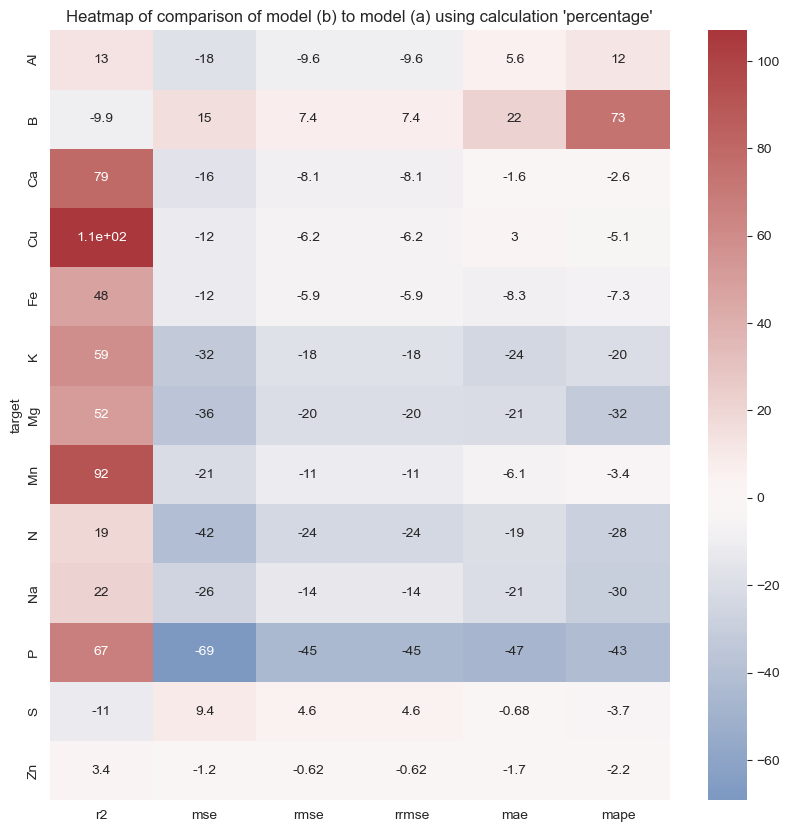

In [10]:
def visualise(df: pd.DataFrame, calc: str):

    figure, ax = plt.subplots(figsize=(10, 10))
    sns.set_style("whitegrid")
    r = sns.heatmap(df, center=0, cmap="vlag", annot=True, ax=ax)
    r.set_title(f"Heatmap of comparison of model (b) to model (a) using calculation '{calc}'")

visualise(r, "percentage")

This shows that - to be consistent in terms of showing an improvement, all metrics (apart from $R^2$) in percentage terms need to be shown as the opposite +/- given that the a large negative in these cases means an improvement given they are tracking the error. So we need to use 1-error score in the calculation. Lets check ratio and difference.

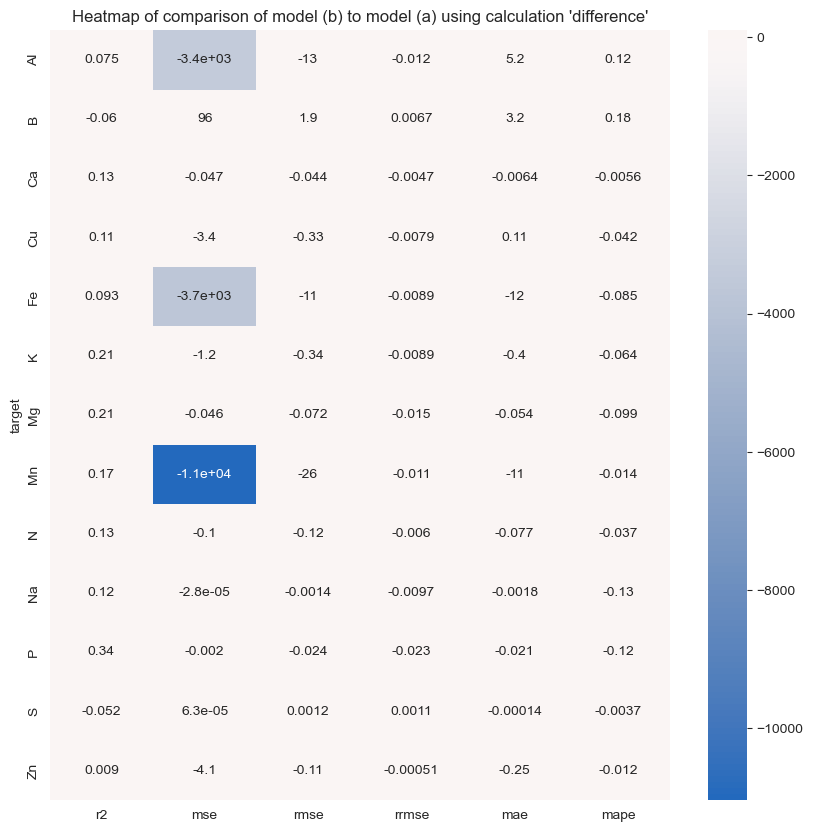

In [11]:
r = compare_results(metrics1.aggregate(["target"]), metrics2.aggregate(["target"]), "difference")
visualise(r, "difference")

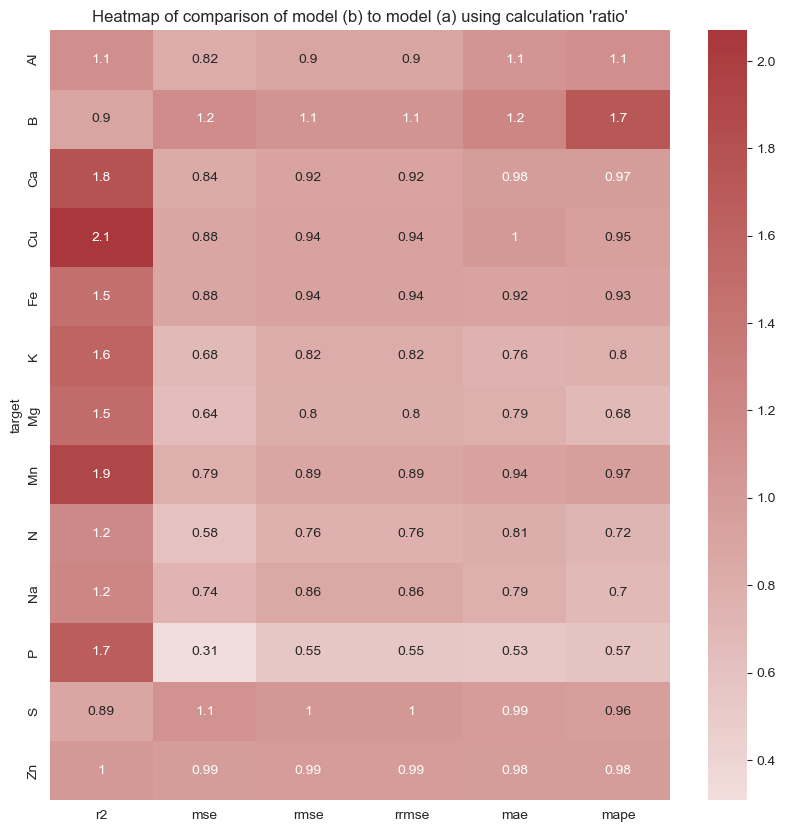

In [12]:
r = compare_results(metrics1.aggregate(["target"]), metrics2.aggregate(["target"]), "ratio")
visualise(r, "ratio")

This shows that the heatmaps aren't so useful with difference, because the score values can be so significantly different. However, percentage show useful information but the error scores do need to have their sign flipped ideally so that positive results highlight an improvement across the scores. Ratio too should be changed when visualising so that greater than 1 highlights an improvement from a to b, aligning with r2 score.

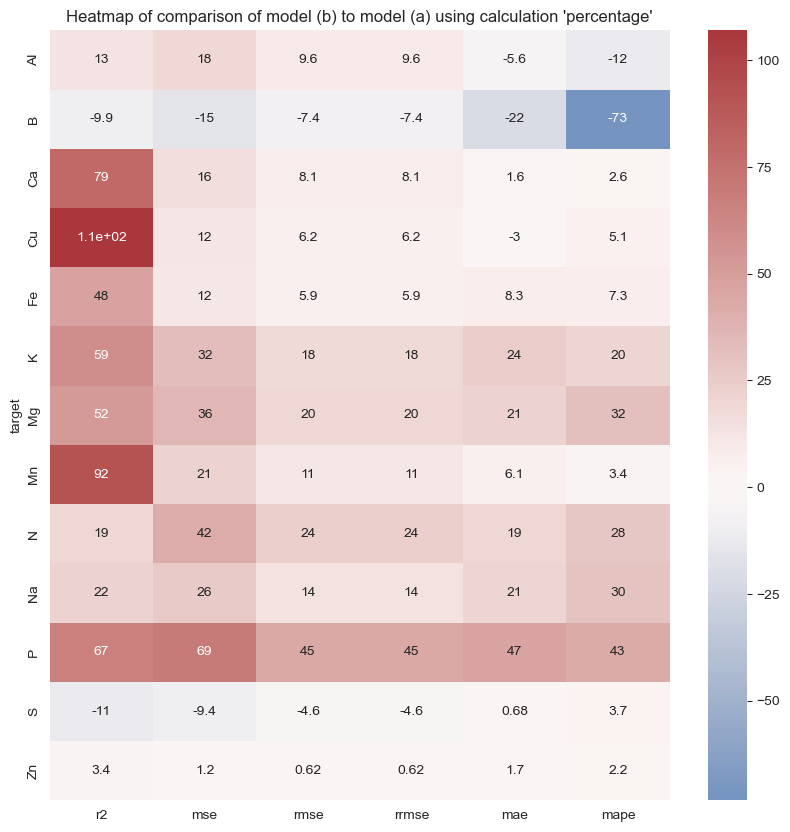

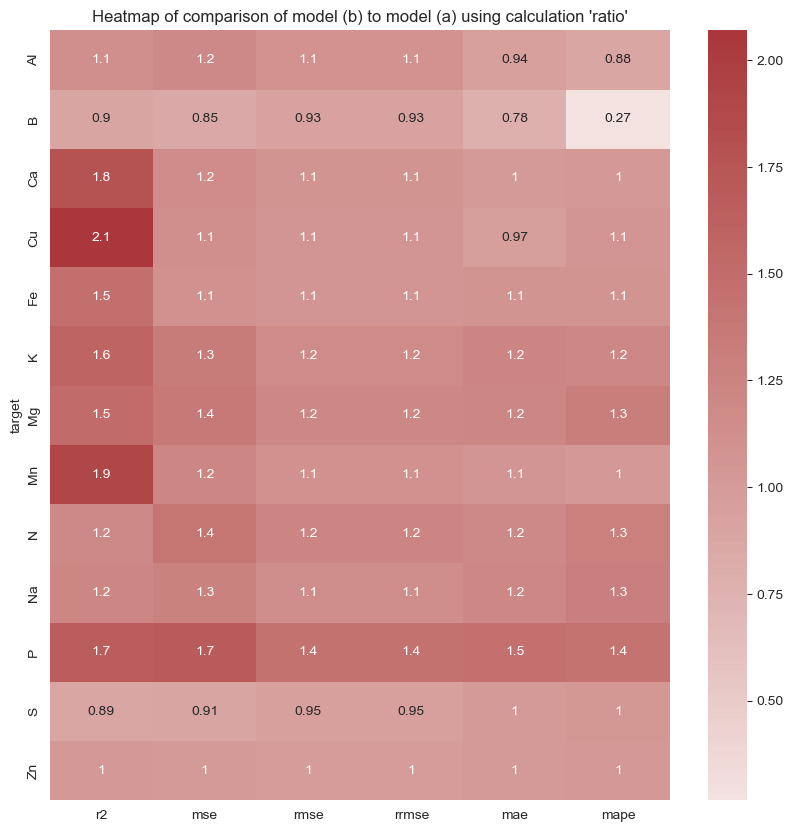

In [14]:
def visualise(df: pd.DataFrame, calc: str):
    r = df.copy()
    r_error_cols = [col for col in r.columns if col != "r2"]
    if calc == "percentage": # Change signs for errors to positive where there is improvement
        r[r_error_cols] = -r[r_error_cols]
    if calc == "ratio":
        r[r_error_cols] = 1 + (1 - r[r_error_cols])
    figure, ax = plt.subplots(figsize=(10, 10))
    sns.set_style("whitegrid")
    hm = sns.heatmap(r, center=0, cmap="vlag", annot=True, ax=ax)
    hm.set_title(f"Heatmap of comparison of model (b) to model (a) using calculation '{calc}'")

r = compare_results(metrics1.aggregate(["target"]), metrics2.aggregate(["target"]), "percentage")
visualise(r, "percentage")

r = compare_results(metrics1.aggregate(["target"]), metrics2.aggregate(["target"]), "ratio")
visualise(r, "ratio")

Now a separate test on the class created with the above functions.


------- Loading data -------
Loading data for dataset ( DRIED | 2 )
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 144 samples.

------- Partition data -------
Train set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.

Test set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.
Now partitioning features and targets for train data...
X and y have shapes (115, 4200), (115, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.
Now partitioning features and targets for test data...
X and y have shapes (29, 4200), (29, 13):

------- Finding best parameter -------
Comparing train and test features...
Comparing train and test targets..

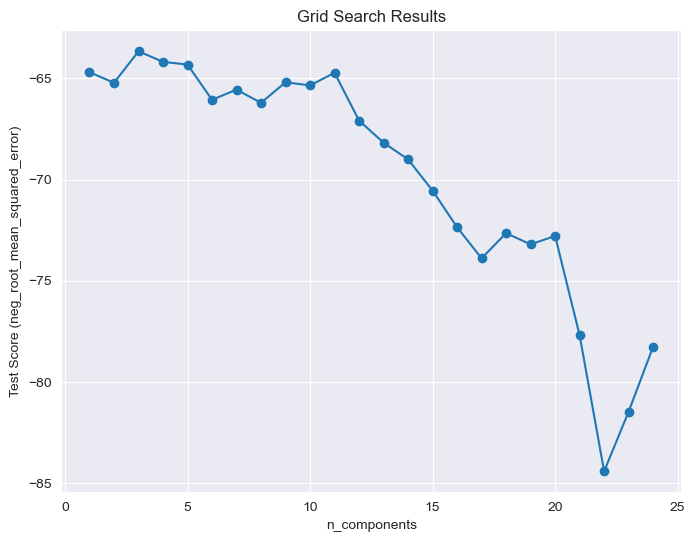


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.

------- Loading data -------
Loading data for dataset ( DRIED | 3 )
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 117 samples.

------- Partition data -------
Train set composition:
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 93 samples.

Test set composition:
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 24 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 76 samples.
Now partitioning features and targets for train data...
X and y have shapes (76, 2101), (76, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 22 samples.
Now partitioning features and targets for test data.

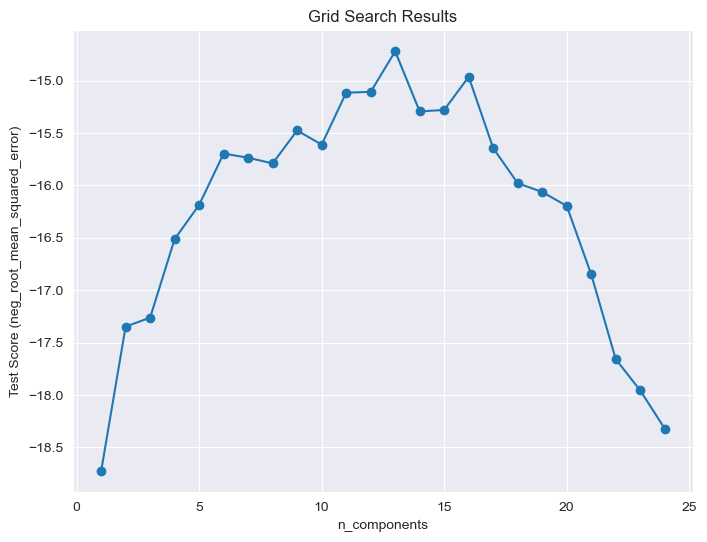


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.


In [56]:
pls_a = PLSEstimator()
pls_a.load_dataset("DRIED", 2)
pls_a.partition(test_size=0.2)
pls_a.preprocess("train", 0.5, 0.5, 0.5, impute_target_method="knn", impute_feature_method="neighbour_avg")
pls_a.preprocess("test", 0.5, 1.1, 0.2, impute_target_method=None, impute_feature_method="neighbour_avg")
pls_a.find_component()
pls_a.fit_predict()

pls_b = PLSEstimator()
pls_b.load_dataset("DRIED", 3)
pls_b.partition(test_size=0.2)
pls_b.preprocess("train", 0.5, 0.5, 0.5, impute_target_method="knn", impute_feature_method="neighbour_avg")
pls_b.preprocess("test", 0.5, 1.1, 0.2, impute_target_method=None, impute_feature_method="neighbour_avg")
pls_b.find_component()
pls_b.fit_predict()

metrics_a = Metrics(pls_a.y_pred, pls_a.y_test)
metrics_b = Metrics(pls_b.y_pred, pls_b.y_test)

In [16]:
from spectroscopy import CompareMetrics

In [17]:
compare = CompareMetrics(metrics1.results, metrics2.results)

DataFrame has a multilevel index. Function requires that both dataframes have a single level row index of element names.
No comparison dataframe has been created.


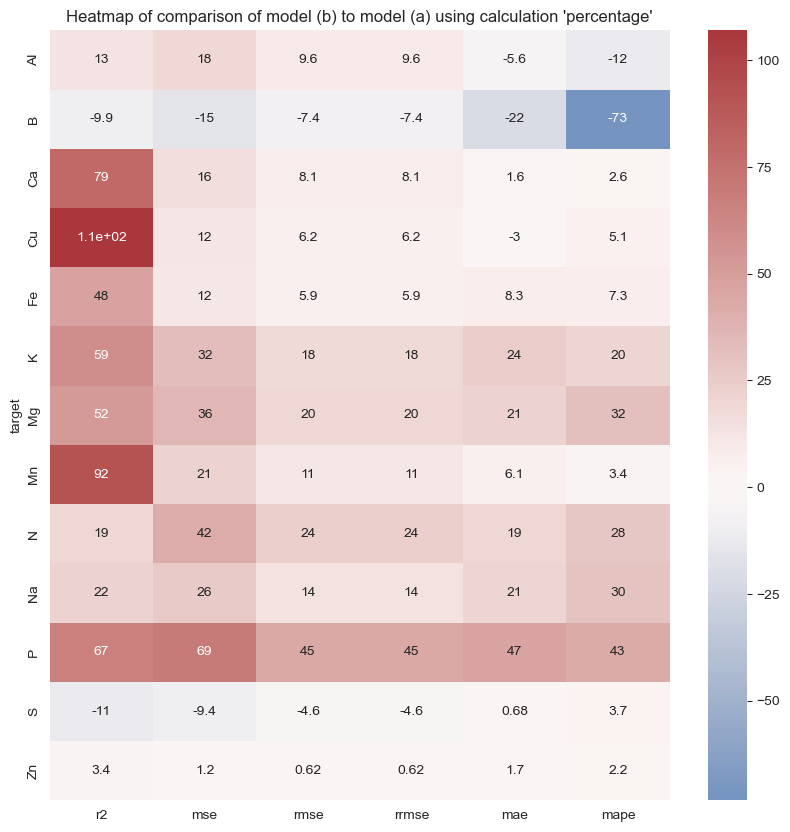

In [24]:
compare = CompareMetrics(metrics1.aggregate(["target"]), metrics2.aggregate(["target"]))